In [18]:
import torch
from torch.utils.data import DataLoader

import sys
from transformers import (
    ViTForImageClassification,
    AutoConfig
)

import pandas as pd
import numpy as np

sys.path.append('..')
from src.chexpert import CheXpertDataset

pathologies = ['Atelectasis',
                'Cardiomegaly',
                'Consolidation',
                'Edema',
                'Pleural Effusion']

def get_predictions(ckpts, approach, train=False):
    dataset = CheXpertDataset(
                data_path=r'E:/',
                uncertainty_policy=approach,
                train=False,
                resize_shape=(224, 224))
    dataloader = DataLoader(dataset, batch_size=dataset.__len__(), shuffle=False)


    models = []
    for checkpoint in ckpts:
        model = ViTForImageClassification.from_pretrained(
            f"../models/base-vit/{approach}/checkpoint-{checkpoint}"
        ).eval()
        models.append(model)

    general_output = []
    for i_model, model in enumerate(models):
        multiindex = pd.MultiIndex.from_product([[f'model_{i_model}'], pathologies], names=['model', 'pathology'])
        for i_batch, sample_batched in enumerate(dataloader):
            with torch.no_grad():
                model_output = pd.DataFrame(model(sample_batched['pixel_values']).logits.numpy(), columns=multiindex)
                labels = pd.DataFrame(sample_batched['labels'], columns=pd.MultiIndex.from_product([['labels'], pathologies]))

        if len(general_output) == 0:
            general_output = pd.merge(labels, model_output, left_index=True, right_index=True).copy()
        else:
            general_output = pd.merge(general_output, model_output, left_index=True, right_index=True)
    return general_output

In [19]:
ckpts = ['622', '1244', '1867', '2489', '3111', '3734', '4356', '4979', '5601', '6220']
approach = 'U-Ignore'

ignore_results = get_predictions(ckpts, approach)
ignore_results.to_parquet(f'results/{approach}.pqt')

In [20]:
ckpts = ['872', '1745', '2618', '3490', '4363', '5236', '6108', '6981', '7854', '8720']
approach = 'U-MultiClass'

multiclass_results = get_predictions(ckpts, approach)
multiclass_results.to_parquet(f'results/{approach}.pqt')

In [21]:
ckpts = ['872', '1745', '2618', '3490', '4363', '5236', '6108', '6981', '7854', '8720']
approach = 'U-Ones'

ones_results = get_predictions(ckpts, approach)
ones_results.to_parquet(f'results/{approach}.pqt')

In [22]:
ckpts = ['872', '1745', '2618', '3490', '4363', '5236', '6108', '6981', '7854', '8720']
approach = 'U-Zeros'

zeros_results = get_predictions(ckpts, approach)
zeros_results.to_parquet(f'results/{approach}.pqt')

# Experimental Results

In [26]:
import pandas as pd

ignore_results = pd.read_parquet('results/U-Ignore.pqt')
multiclass_results = pd.read_parquet('results/U-MultiClass.pqt')
ones_results = pd.read_parquet('results/U-Zeros.pqt')
zeros_results = pd.read_parquet('results/U-Ones.pqt')

In [71]:
from sklearn.metrics import roc_auc_score, RocCurveDisplay
import math

def sigmoid(x):
    return 1 / (1 + math.exp(-x))

pathologies = ['Atelectasis',
                'Cardiomegaly',
                'Consolidation',
                'Edema',
                'Pleural Effusion']

models_names = [f"model_{i_model}" for i_model in range(10)]
multiindex = pd.MultiIndex.from_product([models_names, pathologies], names=['model', 'pathology'])

def get_roc_score(model_results):
    pred_total = pd.DataFrame(index=pd.Index(range(len(model_results))), columns=multiindex)
    roc_score_results = pd.DataFrame([], columns=['AUC'], index=pathologies)

    for pathology in pathologies:
        pred_total.loc[:, (models_names, pathology)] = model_results.loc[:, (models_names, pathology)].map(sigmoid)
        pred_total['Mean', pathology] = pred_total.loc[:, (models_names, pathology)].mean(axis=1)

        true = model_results.loc[:, ('labels', pathology)]
        pred = pred_total.loc[:, ('Mean', pathology)]
        roc_score_results.loc[pathology, 'AUC'] = roc_auc_score(true, pred)

    return roc_score_results, pred_total

In [72]:
ones_auc_score, pred_ones = get_roc_score(ones_results)
ones_auc_score

,AUC
Atelectasis,0.763555
Cardiomegaly,0.810064
Consolidation,0.872456
Edema,0.866196
Pleural Effusion,0.924122


In [74]:
ignore_auc_score, pred_ignore = get_roc_score(ignore_results)
multi_auc_score, pred_multi = get_roc_score(multiclass_results)
ones_auc_score, pred_ones = get_roc_score(ones_results)
zeros_auc_score, pred_zeros = get_roc_score(zeros_results)

In [96]:
import compare_auc_delong_xu
import importlib
importlib.reload(compare_auc_delong_xu)
from scipy import stats

def get_intervals(labels, preds):
    alpha = .95

    auc, auc_cov = compare_auc_delong_xu.delong_roc_variance(
        labels,
        preds
    )

    auc_std = np.sqrt(auc_cov)
    lower_upper_q = np.abs(np.array([0, 1]) - (1 - alpha) / 2)

    ci = stats.norm.ppf(
        lower_upper_q,
        loc=auc,
        scale=auc_std)

    ci[ci > 1] = 1

    print('AUC:', auc)
    print('AUC COV:', auc_cov)
    print('95% AUC CI:', ci)

    return auc, ci


In [97]:
auc, ci = get_intervals(
    ones_results[('labels', 'Atelectasis')].to_numpy(),
    pred_ones[('Mean', 'Atelectasis')].to_numpy()
)

AUC: 0.7635551948051947
AUC COV: 0.0009817839624516682
95% AUC CI: [0.7021428  0.82496759]


In [ ]:
auc, ci = get_intervals(
    ones_results[('labels', 'Atelectasis')].to_numpy(),
    pred_ones[('Mean', 'Atelectasis')].to_numpy()
)

# Relabel uncertainty

In [ ]:
ckpts = ['622', '1244', '1867', '2489', '3111', '3734', '4356', '4979', '5601', '6220']
approach = 'U-Ignore'
train = False

ignore_results = get_predictions(ckpts, approach, train)
ignore_results.to_parquet(f'{approach}.pqt')

: 

: 

In [116]:
import torch
from torch import nn
import numpy as np

from einops import rearrange
from einops.layers.torch import Rearrange

from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

In [220]:
img = np.array(range(224*224*3)).reshape((224,224,3))

In [237]:
img[0:16,0:16,0]

array([[    0,     3,     6,     9,    12,    15,    18,    21,    24,
           27,    30,    33,    36,    39,    42,    45],
       [  672,   675,   678,   681,   684,   687,   690,   693,   696,
          699,   702,   705,   708,   711,   714,   717],
       [ 1344,  1347,  1350,  1353,  1356,  1359,  1362,  1365,  1368,
         1371,  1374,  1377,  1380,  1383,  1386,  1389],
       [ 2016,  2019,  2022,  2025,  2028,  2031,  2034,  2037,  2040,
         2043,  2046,  2049,  2052,  2055,  2058,  2061],
       [ 2688,  2691,  2694,  2697,  2700,  2703,  2706,  2709,  2712,
         2715,  2718,  2721,  2724,  2727,  2730,  2733],
       [ 3360,  3363,  3366,  3369,  3372,  3375,  3378,  3381,  3384,
         3387,  3390,  3393,  3396,  3399,  3402,  3405],
       [ 4032,  4035,  4038,  4041,  4044,  4047,  4050,  4053,  4056,
         4059,  4062,  4065,  4068,  4071,  4074,  4077],
       [ 4704,  4707,  4710,  4713,  4716,  4719,  4722,  4725,  4728,
         4731,  4734,  473

In [234]:
img[0:16,0:16,:]#.shape

array([[[    0,     1,     2],
        [    3,     4,     5],
        [    6,     7,     8],
        [    9,    10,    11],
        [   12,    13,    14],
        [   15,    16,    17],
        [   18,    19,    20],
        [   21,    22,    23],
        [   24,    25,    26],
        [   27,    28,    29],
        [   30,    31,    32],
        [   33,    34,    35],
        [   36,    37,    38],
        [   39,    40,    41],
        [   42,    43,    44],
        [   45,    46,    47]],

       [[  672,   673,   674],
        [  675,   676,   677],
        [  678,   679,   680],
        [  681,   682,   683],
        [  684,   685,   686],
        [  687,   688,   689],
        [  690,   691,   692],
        [  693,   694,   695],
        [  696,   697,   698],
        [  699,   700,   701],
        [  702,   703,   704],
        [  705,   706,   707],
        [  708,   709,   710],
        [  711,   712,   713],
        [  714,   715,   716],
        [  717,   718,   719]],

    

In [223]:
tensor_img = torch.from_numpy(img)

In [224]:
tensor_img.shape

torch.Size([224, 224, 3])

In [227]:
rearranged = Rearrange("(h p1) (w p2) c -> (h w) (p1 p2 c)", p1 = 16, p2 = 16)(tensor_img)
rearranged.shape

torch.Size([196, 768])

In [230]:
rearranged[0, :]

tensor([    0,     1,     2,     3,     4,     5,     6,     7,     8,     9,
           10,    11,    12,    13,    14,    15,    16,    17,    18,    19,
           20,    21,    22,    23,    24,    25,    26,    27,    28,    29,
           30,    31,    32,    33,    34,    35,    36,    37,    38,    39,
           40,    41,    42,    43,    44,    45,    46,    47,   672,   673,
          674,   675,   676,   677,   678,   679,   680,   681,   682,   683,
          684,   685,   686,   687,   688,   689,   690,   691,   692,   693,
          694,   695,   696,   697,   698,   699,   700,   701,   702,   703,
          704,   705,   706,   707,   708,   709,   710,   711,   712,   713,
          714,   715,   716,   717,   718,   719,  1344,  1345,  1346,  1347,
         1348,  1349,  1350,  1351,  1352,  1353,  1354,  1355,  1356,  1357,
         1358,  1359,  1360,  1361,  1362,  1363,  1364,  1365,  1366,  1367,
         1368,  1369,  1370,  1371,  1372,  1373,  1374,  1375, 

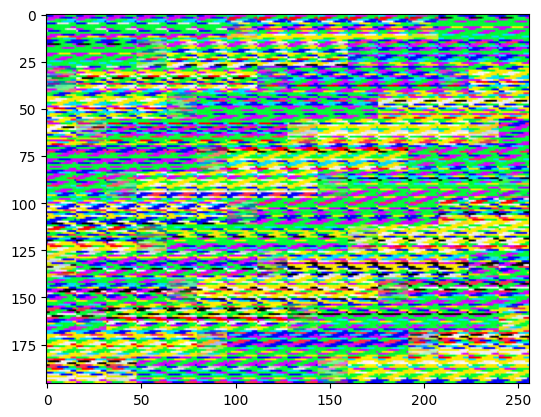

In [216]:
plt.imshow(rearranged)
plt.show()

In [159]:
rearranged.shape

torch.Size([196, 768])

In [160]:
nn.Linear(3*16*16, 1024)(rearranged)

RuntimeError: mat1 and mat2 must have the same dtype